# DeepAR in Wiki data

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/AustralianDomesticTourism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In many cases, only the time series at the lowest level of the hierarchies (bottom time series) are available. `HierarchicalForecast` has tools to create time series for all hierarchies. In this notebook we will see how to do it.

In [1]:

# compute base forecast no coherent
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive
import pandas as pd

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut
from datasetsforecast.hierarchical import HierarchicalData
import numpy as np
from statsforecast.models import ETS


/home/arindam/anaconda3/envs/kdd23/lib/python3.9/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Aggregate bottom time series

In this example we will use the [Tourism](https://otexts.com/fpp3/tourism.html) dataset from the [Forecasting: Principles and Practice](https://otexts.com/fpp3/) book. The dataset only contains the time series at the lowest level, so we need to create the time series for all hierarchies.

In [2]:
# Load TourismSmall dataset
Y_df, S, tags = HierarchicalData.load('./data', 'Wiki2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [3]:
Y_df

,unique_id,ds,y
0,Total,2016-01-01,156508
1,Total,2016-01-02,129902
2,Total,2016-01-03,138203
3,Total,2016-01-04,115017
4,Total,2016-01-05,126042
...,...,...,...
72829,zh_MOB_AAG_138,2016-12-27,69
72830,zh_MOB_AAG_138,2016-12-28,64
72831,zh_MOB_AAG_138,2016-12-29,94
72832,zh_MOB_AAG_138,2016-12-30,99


In [4]:
unq_ids = Y_df["unique_id"].unique()
len(unq_ids)

199

In [5]:
len(Y_df[Y_df["unique_id"] == unq_ids[0]])

366

In [6]:
S

,de_AAC_AAG_001,de_AAC_AAG_010,de_AAC_AAG_014,de_AAC_AAG_045,de_AAC_AAG_063,de_AAC_AAG_100,de_AAC_AAG_110,de_AAC_AAG_123,de_AAC_AAG_143,de_AAC_SPD_012,...,zh_DES_AAG_054,zh_DES_AAG_056,zh_DES_AAG_068,zh_DES_AAG_089,zh_DES_AAG_139,zh_MOB_AAG_005,zh_MOB_AAG_028,zh_MOB_AAG_031,zh_MOB_AAG_036,zh_MOB_AAG_138
Total,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
de,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
en,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ja,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zh_MOB_AAG_005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
zh_MOB_AAG_028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
zh_MOB_AAG_031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
zh_MOB_AAG_036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
tags

{'Views': array(['Total'], dtype=object),
 'Views/Country': array(['de', 'en', 'fr', 'ja', 'ru', 'zh'], dtype=object),
 'Views/Country/Access': array(['de_AAC', 'de_DES', 'de_MOB', 'en_AAC', 'en_DES', 'en_MOB',
        'fr_AAC', 'fr_DES', 'fr_MOB', 'ja_AAC', 'ja_DES', 'ja_MOB',
        'ru_AAC', 'ru_DES', 'ru_MOB', 'zh_AAC', 'zh_DES', 'zh_MOB'],
       dtype=object),
 'Views/Country/Access/Agent': array(['de_AAC_AAG', 'de_AAC_SPD', 'de_DES_AAG', 'de_MOB_AAG',
        'en_AAC_AAG', 'en_AAC_SPD', 'en_DES_AAG', 'en_MOB_AAG',
        'fr_AAC_AAG', 'fr_AAC_SPD', 'fr_DES_AAG', 'fr_MOB_AAG',
        'ja_AAC_AAG', 'ja_AAC_SPD', 'ja_DES_AAG', 'ja_MOB_AAG',
        'ru_AAC_AAG', 'ru_AAC_SPD', 'ru_DES_AAG', 'ru_MOB_AAG',
        'zh_AAC_AAG', 'zh_AAC_SPD', 'zh_DES_AAG', 'zh_MOB_AAG'],
       dtype=object),
 'Views/Country/Access/Agent/Topic': array(['de_AAC_AAG_001', 'de_AAC_AAG_010', 'de_AAC_AAG_014',
        'de_AAC_AAG_045', 'de_AAC_AAG_063', 'de_AAC_AAG_100',
        'de_AAC_AAG_110', 'de_AAC

In [8]:
len(tags.keys())

5

### Split Train/Test sets

We use the final horizon as test set.

In [9]:
HORIZON = 1
FREQUENCY = "1D"

In [10]:
Y_test_df = Y_df.groupby('unique_id').tail(HORIZON)
Y_train_df = Y_df.drop(Y_test_df.index)

In [11]:
Y_train_df = Y_train_df.set_index("unique_id")
Y_test_df = Y_test_df.set_index("unique_id")

In [12]:
Y_test_df

,ds,y
unique_id,,
Total,2016-12-31,113839
de,2016-12-31,14854
en,2016-12-31,42342
fr,2016-12-31,11835
ja,2016-12-31,16716
...,...,...
zh_MOB_AAG_005,2016-12-31,13
zh_MOB_AAG_028,2016-12-31,17
zh_MOB_AAG_031,2016-12-31,555


In [13]:
Y_train_df.groupby('unique_id').size()

unique_id
Total             365
de                365
de_AAC            365
de_AAC_AAG        365
de_AAC_AAG_001    365
                 ... 
zh_MOB_AAG_005    365
zh_MOB_AAG_028    365
zh_MOB_AAG_031    365
zh_MOB_AAG_036    365
zh_MOB_AAG_138    365
Length: 199, dtype: int64

## Computing base forecasts

The following cell computes the **base forecasts** for each time series in `Y_df` using the `auto_arima` and `naive` models. Observe that `Y_hat_df` contains the forecasts but they are not coherent.

In [14]:
# Convert train df to gluonts format
# from data_utils import convert_df_to_gluonts_iter

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

def convert_df_to_gluonts_iter(df: pd.DataFrame, horizon: int, frequency: str):

    unq_ids = np.unique(df.index)

    all_ts = []
    for id_ in unq_ids:
        df_one_ts = df[df.index == id_].sort_values("ds")
        start_time = df_one_ts["ds"][0]
        target_vals = df_one_ts["y"].values
        # print(id_, start_time, target_vals)
        all_ts.append(
            {
                FieldName.TARGET: target_vals,
                FieldName.START: start_time,
                FieldName.ITEM_ID: id_
            }
        )
    return ListDataset(all_ts, freq=frequency)

gluon_dset_train = convert_df_to_gluonts_iter(Y_train_df, HORIZON, FREQUENCY)
gluon_dset_test = convert_df_to_gluonts_iter(Y_df.set_index('unique_id'), HORIZON, FREQUENCY)

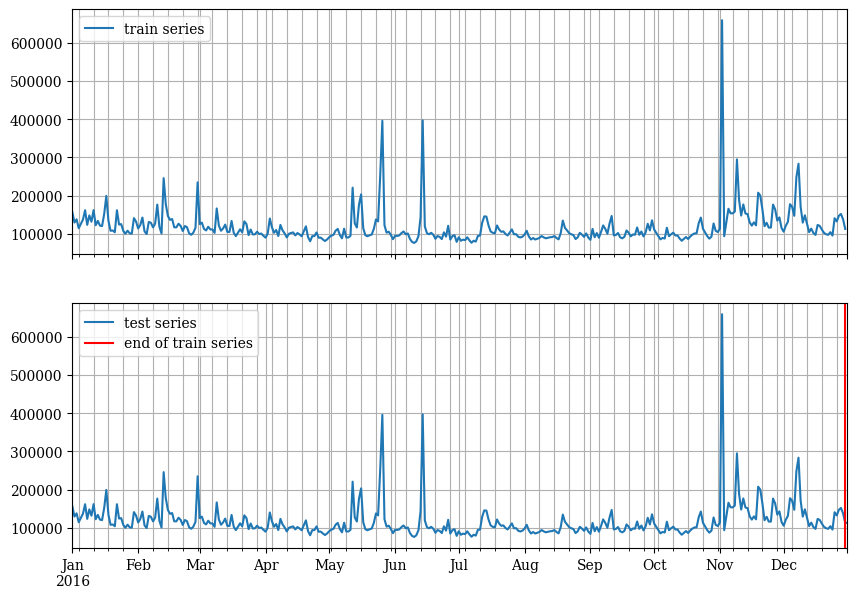

In [15]:
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas

train_entry = next(iter(gluon_dset_train))
test_entry = next(iter(gluon_dset_test))

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()



In [16]:

from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

EPOCHS = 10
FREQ = FREQUENCY
LR = 1e-3
BATCHES_PER_EPOCH = 100

# Get best model params from HPO
CONTEXT_LEN = 40*HORIZON
# num_layers = 2
# dropout_rate = 0.4
# EPOCHS = 25
# num_cells = 40

estimator = DeepAREstimator(
    freq=FREQ,
    prediction_length=HORIZON,
    trainer=Trainer(ctx="cpu", epochs=EPOCHS, learning_rate=1e-3, num_batches_per_epoch=BATCHES_PER_EPOCH),
    context_length=CONTEXT_LEN,
    scaling=True,
    # num_layers=num_layers,
    # num_cells=num_cells, 
    # dropout_rate=dropout_rate
)

predictor = estimator.train(gluon_dset_train)

# # Fit and predict with N-BEATS and N-HiTS models
# models = [NBEATS(input_size=CONTEXT_LEN, h=HORIZON, max_epochs=EPOCHS)]
# fcst = NeuralForecast(models=models, freq='M')
# fcst.fit(df=Y_train_df)

INFO:gluonts.mx.context:Using CPU
/home/arindam/anaconda3/envs/kdd23/lib/python3.9/site-packages/gluonts/model/deepar/__init__.py:18: FutureWarning: The module gluonts.model.deepar has been moved to gluonts.mx.model.deepar. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import DeepAREstimator'.
  warnings.warn(
INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:26<00:00,  3.83it/s, epoch=1/10, avg_epoch_loss=6.6]
INFO:gluonts.trainer:Epoch[0] Elapsed time 26.143 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=6.603781
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:23<00:00,  4.24it/s, epoch=2/10, avg_epoch_loss=6.25]
INFO:gluonts.trainer:Epoch[1] Elapsed time 23.605 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=6.248274
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████|

In [17]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=gluon_dset_test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

### Convert the forecasts iterator into pandas df

In [18]:
def convert_gluonts_iter_to_df(
    gluon_iter,
    test_dates
):
    out = []
    dates = []
    ids = []
    for x in gluon_iter:
        ids.extend([x.item_id]*HORIZON)
        out.extend(np.mean(x.samples, axis=0).reshape(-1))
        dates.extend(test_dates)
    out = pd.DataFrame({"unique_id": ids, "ds": dates, "y_hat": out})
    out = out.set_index("unique_id")
    return out

test_dates = Y_test_df["ds"].unique()
test_dates.sort()
forecast_df = convert_gluonts_iter_to_df(forecasts, test_dates)
print(forecast_df)

                       ds          y_hat
unique_id                               
Total          2016-12-31  118487.992188
de             2016-12-31   13201.151367
de_AAC         2016-12-31    6436.684570
de_AAC_AAG     2016-12-31    6284.012695
de_AAC_AAG_001 2016-12-31     284.374451
...                   ...            ...
zh_MOB_AAG_005 2016-12-31      12.443103
zh_MOB_AAG_028 2016-12-31      20.013578
zh_MOB_AAG_031 2016-12-31     515.973389
zh_MOB_AAG_036 2016-12-31      81.481049
zh_MOB_AAG_138 2016-12-31      87.151237

[199 rows x 2 columns]


### Computing in-sample forecasts needed for MinT, ERM methods
Note that the model is already trained on the training part of the data. Now, the in-sample forecasts are obtained by a moving window method. These in-sample forecasts are needed to estimate the residual covariance matrix in MinT and ERM methods.

In [19]:
dates = Y_df.ds.unique()
dates.sort()
dates_train = Y_train_df.ds.unique()
dates_train.sort()
Y_hat_in_sample = None
for i in range(0, len(dates_train)-HORIZON-CONTEXT_LEN+1):
    # print(i, i+CONTEXT_LEN, i+CONTEXT_LEN+HORIZON)
    backtest_history = Y_train_df[(Y_train_df.ds >= dates[i]) & (Y_train_df.ds < dates[i+CONTEXT_LEN])]
    end_pt = i+CONTEXT_LEN+HORIZON
    if end_pt < len(dates_train):
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN]) & (Y_train_df.ds < dates[end_pt])]
    else:
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN])]
    # print(len(backtest_test_true))
    backtest_history_iter = convert_df_to_gluonts_iter(backtest_history, HORIZON, FREQUENCY)
    forecast_it, ts_it = make_evaluation_predictions(
                            dataset=backtest_history_iter,  # test dataset
                            predictor=predictor,  # predictor
                            num_samples=100,  # number of sample paths we want for evaluation
                        )
    forecasts = list(forecast_it)
    # Y_hat_in_sample_part = fcst.predict(df=backtest_history)
    test_dates = backtest_test_true["ds"].unique()
    test_dates.sort()
    Y_hat_in_sample_part = convert_gluonts_iter_to_df(forecasts, test_dates)
    # Y_hat_in_sample_part["ds"] = backtest_test_true["ds"].values
    first_horizon_date = backtest_test_true["ds"].unique()[0]
    if Y_hat_in_sample is None:
        Y_hat_in_sample = Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]
    else:
        if i == len(dates_train)-HORIZON-CONTEXT_LEN:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part])
        else:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]])

In [20]:
Y_hat_in_sample_part

,ds,y_hat
unique_id,,
Total,2016-12-30,129334.343750
de,2016-12-30,12572.767578
de_AAC,2016-12-30,5673.778809
de_AAC_AAG,2016-12-30,5612.709961
de_AAC_AAG_001,2016-12-30,338.073425
...,...,...
zh_MOB_AAG_005,2016-12-30,12.861402
zh_MOB_AAG_028,2016-12-30,19.167147
zh_MOB_AAG_031,2016-12-30,395.130615


## Predict on test

In [21]:
Y_hat_df = forecast_df
Y_hat_df

,ds,y_hat
unique_id,,
Total,2016-12-31,118487.992188
de,2016-12-31,13201.151367
de_AAC,2016-12-31,6436.684570
de_AAC_AAG,2016-12-31,6284.012695
de_AAC_AAG_001,2016-12-31,284.374451
...,...,...
zh_MOB_AAG_005,2016-12-31,12.443103
zh_MOB_AAG_028,2016-12-31,20.013578
zh_MOB_AAG_031,2016-12-31,515.973389


In [22]:
# Create Y_df with y_hat_in_sample
Y_train_df_extended = Y_train_df.merge(Y_hat_in_sample, on=["ds", "unique_id"], how="inner")
Y_train_df_extended

,ds,y,y_hat
unique_id,,,
Total,2016-02-10,176772,113075.648438
Total,2016-02-11,118612,122727.187500
Total,2016-02-12,101196,130848.828125
Total,2016-02-13,245884,134277.671875
Total,2016-02-14,178155,122328.960938
...,...,...,...
zh_MOB_AAG_138,2016-12-26,75,81.075272
zh_MOB_AAG_138,2016-12-27,69,72.558487
zh_MOB_AAG_138,2016-12-28,64,61.099659


## Reconcile forecasts

The following cell makes the previous forecasts coherent using the `HierarchicalReconciliation` class. Since the hierarchy structure is not strict, we can't use methods such as `TopDown` or `MiddleOut`. In this example we use `BottomUp` and `MinTrace`.

In [23]:
from hierarchicalforecast.methods import BottomUp, MinTrace, ERM

reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols'),
    ERM(method='reg')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df_extended, S=S, tags=tags)

The dataframe `Y_rec_df` contains the reconciled forecasts.

In [24]:
Y_rec_df

,ds,y_hat,y_hat/BottomUp,y_hat/MinTrace_method-mint_shrink,y_hat/MinTrace_method-ols,y_hat/ERM_method-reg_lambda_reg-0.01
unique_id,,,,,,
Total,2016-12-31,118487.992188,110265.148438,116951.467503,118766.646412,103640.343750
de,2016-12-31,13201.151367,11084.810547,12311.534310,12698.080236,9509.234375
en,2016-12-31,47176.414062,44381.582031,45460.174579,46193.567356,41020.925781
fr,2016-12-31,14018.391602,11959.938477,13278.382761,13648.312161,13267.884766
ja,2016-12-31,20530.212891,18393.455078,20029.833459,20181.570585,16448.175781
...,...,...,...,...,...,...
zh_MOB_AAG_005,2016-12-31,12.443103,12.443103,12.327862,53.129786,14.464216
zh_MOB_AAG_028,2016-12-31,20.013578,20.013578,21.412462,60.700262,18.916790
zh_MOB_AAG_031,2016-12-31,515.973389,515.973389,579.505725,556.660072,424.815613


## Evaluation 

The `HierarchicalForecast` package includes the `HierarchicalEvaluation` class to evaluate the different hierarchies and also is capable of compute scaled metrics compared to a benchmark model.

In [25]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

def rmse(y, y_hat):
    return np.mean(np.sqrt(np.mean((y-y_hat)**2, axis=1)))

def mase(y, y_hat, y_insample, seasonality=4):
    errors = np.mean(np.abs(y - y_hat), axis=1)
    scale = np.mean(np.abs(y_insample[:, seasonality:] - y_insample[:, :-seasonality]), axis=1)
    return np.mean(errors / scale)

def rmsse(y, y_hat, y_insample):
    errors = np.mean(np.square(y - y_hat), axis=1)
    scale = np.mean(np.square(y_insample[:, 1:] - y_insample[:, :-1]), axis=1)
    return np.mean(np.sqrt(errors / scale))

eval_tags = {}
for k in tags.keys():
    eval_tags[k] = tags[k]

evaluator = HierarchicalEvaluation(evaluators=[rmse, mase, rmsse])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=eval_tags, Y_df=Y_train_df
)
evaluation = evaluation.drop('Overall')
# evaluation.columns = ['Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
evaluation.columns = ['Base', 'BottomUp', 'MinTrace(ols)', 'MinTrace(mint_shrink)', 'ERM']
evaluation = evaluation.applymap('{:.4f}'.format)

### RMSE

The following table shows the performance measured using RMSE across levels for each reconciliation method.

In [26]:
score_df = evaluation.query('metric == "rmse"')
score_df

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Views,rmse,4648.9922,3573.8516,3112.4675,4927.6464,10198.6562
Views/Country,rmse,3161.6691,2635.0415,2974.7056,3042.3970,2315.9902
Views/Country/Access,rmse,1621.2749,1551.0499,1573.0747,1613.9172,1362.7162
Views/Country/Access/Agent,rmse,1400.5837,1356.1662,1372.7222,1434.3368,1210.9088
Views/Country/Access/Agent/Topic,rmse,286.7585,286.7585,302.8566,321.3096,277.5390


### MASE


The following table shows the performance measured using MASE across levels for each reconciliation method.

In [27]:
evaluation.query('metric == "mase"')

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Views,mase,0.1589,0.1222,0.1064,0.1685,0.3487
Views/Country,mase,0.6175,0.5499,0.6058,0.6117,0.4970
Views/Country/Access,mase,0.5569,0.5577,0.5210,0.5801,0.5224
Views/Country/Access/Agent,mase,0.8103,0.7990,0.7577,1.2247,0.7463
Views/Country/Access/Agent/Topic,mase,0.8429,0.8429,0.8760,1.3115,0.8732


### RMSSE

In [28]:
score_df = evaluation.query('metric == "rmsse"')
score_df

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Views,rmsse,0.0836,0.0643,0.0560,0.0886,0.1835
Views/Country,rmsse,0.3549,0.3192,0.3465,0.3525,0.2976
Views/Country/Access,rmsse,0.2763,0.2721,0.2577,0.2959,0.2783
Views/Country/Access/Agent,rmsse,0.4639,0.4517,0.4313,0.7110,0.4445
Views/Country/Access/Agent/Topic,rmsse,0.4666,0.4666,0.4775,0.7299,0.4643


In [29]:
score_df.astype(float).mean()

Base                     0.32906
BottomUp                 0.31478
MinTrace(ols)            0.31380
MinTrace(mint_shrink)    0.43558
ERM                      0.33364
dtype: float64

### Comparison fable

Observe that we can recover the results reported by the [Forecasting: Principles and Practice](https://otexts.com/fpp3/tourism.html). The original results were calculated using the R package [fable](https://github.com/tidyverts/fable).

![Fable's reconciliation results](./imgs/AustralianDomesticTourism-results-fable.png)

### References
- [Hyndman, R.J., & Athanasopoulos, G. (2021). "Forecasting: principles and practice, 3rd edition: 
Chapter 11: Forecasting hierarchical and grouped series.". OTexts: Melbourne, Australia. OTexts.com/fpp3 
Accessed on July 2022.](https://otexts.com/fpp3/hierarchical.html)
- [Rob Hyndman, Alan Lee, Earo Wang, Shanika Wickramasuriya, and Maintainer Earo Wang (2021). "hts: Hierarchical and Grouped Time Series". URL https://CRAN.R-project.org/package=hts. R package version 0.3.1.](https://cran.r-project.org/web/packages/hts/index.html)
- [Mitchell O’Hara-Wild, Rob Hyndman, Earo Wang, Gabriel Caceres, Tim-Gunnar Hensel, and Timothy Hyndman (2021). "fable: Forecasting Models for Tidy Time Series". URL https://CRAN.R-project.org/package=fable. R package version 6.0.2.](https://CRAN.R-project.org/package=fable)